In [7]:
# transfer of learning for perturbation, using the idea of backprop + hebbian
# need to first find the optimum weight sum when perturbation, otherwise, the loss would shoot up
# it happens that not giving boundary to perturbation period while giving boundary to non-perturbation period produces the best result
# giving boundary might cause convergence to boundary (high loss), for example, when shifts want to jump below 1
# not giving boundary might sink into a local minimum where the loss is really low but gains and shifts are deviant from initial
# may not be generalizable, a better method for narrowing the boundary??
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_bphebb import SimpleNeuralNetwork
from tqdm.notebook import tqdm

In [8]:
# load the pickle file
with open('weights_abb05_bphebb.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [9]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [10]:
# bp on weight to find the hebb alpha for perturbed network
# init
input_size = 230
init_gain = 3 * np.ones((input_size, 1))
init_shift = 1 * np.ones((input_size, 1))
init_weight = np.ones((1, input_size)) * 5.5 / input_size

# Training Loop
weight_epochs = 200
backprop_lr = 0.1

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=weight_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises += 0.1

# record
weight_losses = []
weight_sums = []
# weights = []

for epoch in tqdm(range(weight_epochs), position=0, leave=True):
    
    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    epoch_loss = 0

    # go through all data
    for x, y in zip(shuffled_xs, shuffled_ys):  
        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        
        # backprop
        optimizer = optim.SGD([model.weights], lr=backprop_lr)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    # update init
    init_gain = model.gain.detach().numpy()
    init_shift = model.shift.detach().numpy()
    init_weight = model.weights.detach().numpy()

    # record
    weight_losses.append(epoch_loss)
    weight_sums.append(np.sum(init_weight))

    # print out info
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{weight_epochs}, Loss: {epoch_loss}, Sum: {np.sum(init_weight)}')


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Loss: 0.2715413275698997, Sum: 3.4663703441619873
Epoch 11/200, Loss: 1.6800869838462518e-05, Sum: 3.4811668395996094
Epoch 21/200, Loss: 7.485408430429885e-06, Sum: 3.480985641479492
Epoch 31/200, Loss: 7.783876470934814e-06, Sum: 3.479872226715088
Epoch 41/200, Loss: 8.06518379548038e-06, Sum: 3.4810686111450195
Epoch 51/200, Loss: 7.62484520588913e-06, Sum: 3.4819281101226807
Epoch 61/200, Loss: 6.740080595424303e-06, Sum: 3.4815077781677246
Epoch 71/200, Loss: 6.649135910752335e-06, Sum: 3.4820284843444824
Epoch 81/200, Loss: 7.016859710162748e-06, Sum: 3.4820268154144287
Epoch 91/200, Loss: 8.180438577198856e-06, Sum: 3.4808640480041504
Epoch 101/200, Loss: 6.9877081818603415e-06, Sum: 3.4810142517089844
Epoch 111/200, Loss: 6.364916199430581e-06, Sum: 3.480689287185669
Epoch 121/200, Loss: 7.3142374739099125e-06, Sum: 3.4798474311828613
Epoch 131/200, Loss: 7.160009724671568e-06, Sum: 3.4808952808380127
Epoch 141/200, Loss: 7.838835744067296e-06, Sum: 3.4818739891052

### Perturbation 2000 Epochs

In [11]:
# perturbation for 2000 epochs
simu_epochs = 4000
perturb_start = 50
perturb_last = 2000
input_size = 230
theo_gain = 3 * np.ones((input_size, 1))
theo_shift = 1 * np.ones((input_size, 1))
init_gain = model_rep.gain.detach().numpy()
init_shift = model_rep.shift.detach().numpy()
init_weight = model_rep.weights.detach().numpy()
hebbian_lr = 0.03
max_hebbian_lr = 0.001
hebbian_up_rate = max_hebbian_lr / 200
hebb_alpha = 5.5
hebb_alpha_origin = 5.5
hebb_alpha_perturb = 3.5
hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 200
backprop_lr = 0.2
has_backprop = True
has_boundary = False
has_hebbian = True
has_perturb = False

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

simu_losses = []
gain_changes = []
shift_changes = []
weight_sums = []
epoch_loss = 0

for epoch in tqdm(range(simu_epochs), position=0, leave=True):
    if epoch == perturb_start:
        has_perturb = True
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation start!!!")
    if epoch == perturb_start + perturb_last:
        has_perturb = False
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation end!!!")
    
    # if epoch == perturb_start + perturb_last + 15:
    #     break
    
    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    last_epoch_loss = epoch_loss
    epoch_loss = 0
    hebbian_update = torch.zeros_like(torch.tensor(init_weight))

    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    # start hebbian and shrinkage
    if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("perturb learning start!!!")
    if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("origin learning start!!!")
    # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
    #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
    #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
    #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
    #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
    #     has_boundary = True
    #     print("perturb boundary created!!!")
    if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
        gain_ub = np.maximum(init_gain, theo_gain)
        gain_lb = np.minimum(init_gain, theo_gain)
        shift_ub = np.maximum(init_shift, theo_shift)
        shift_lb = np.minimum(init_shift, theo_shift)
        has_boundary = True
        print("origin boundary created!!!")
        
    # update hebbian learning rate, once per epoch
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_up_rate
    if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
        hebb_alpha += hebb_alpha_up_rate
    if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
        hebb_alpha -= hebb_alpha_up_rate
    
    # go through all data
    for x, y in zip(shuffled_xs, shuffled_ys):  
        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        epoch_loss += loss
        # Calculate Hebbian weight updates
        hebbian_update += model.output_activation * (model.input_activation).T

    # backprop for gains and shifts
    if has_backprop:
        optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
        epoch_loss.backward()
        optimizer.step()
    # update init gains and shifts
    init_gain = model.gain.detach().numpy()
    init_shift = model.shift.detach().numpy()
    gain_change = np.linalg.norm(init_gain - theo_gain, 2)
    shift_change = np.linalg.norm(init_shift - theo_shift, 2)

    # hebbian learning for weights
    if has_hebbian:
        # Apply Hebbian updates and normalize
        model.weights = model.weights + hebbian_lr * hebbian_update
        model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
    # update init weights
    init_weight = model.weights.detach().numpy()

    # shrink shift and gain to init value
    if has_boundary:
        # passively narrow the boundaries
        # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
        # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
        # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
        # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
        # pull gains and shifts back to into boundaries
        init_gain = np.minimum(init_gain, gain_ub)
        init_gain = np.maximum(init_gain, gain_lb)
        init_shift = np.minimum(init_shift, shift_ub)
        init_shift = np.maximum(init_shift, shift_lb)

    # print losses
    epoch_loss /= ndata
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")
        # print(f"Gains: {init_gain[0:10].flatten()}")
        # print(f"Shifts: {init_shift[0:10].flatten()}")

    # record
    simu_losses.append(epoch_loss.item())
    weight_sums.append(np.sum(init_weight))
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0, Loss: 6.917842711118283e-06
Epoch: 20, Loss: 6.912130629643798e-06
Epoch: 40, Loss: 6.910632237122627e-06
perturbation start!!!
Epoch: 60, Loss: 0.004398731980472803
Epoch: 80, Loss: 0.0018013453809544444
Epoch: 100, Loss: 0.0010998104698956013
perturb learning start!!!
Epoch: 120, Loss: 0.0007757330895401537
Epoch: 140, Loss: 0.0006023565656505525
Epoch: 160, Loss: 0.0004716204130090773
Epoch: 180, Loss: 0.00040720723336562514
Epoch: 200, Loss: 0.00037787374458275735
Epoch: 220, Loss: 0.0003652730956673622
Epoch: 240, Loss: 0.0003614546440076083
Epoch: 260, Loss: 0.000362555671017617
Epoch: 280, Loss: 0.0003659155627246946
Epoch: 300, Loss: 0.00036873534554615617
Epoch: 320, Loss: 0.00029527663718909025
Epoch: 340, Loss: 0.00021455030946526676
Epoch: 360, Loss: 0.00015286440611816943
Epoch: 380, Loss: 0.00010766778723336756
Epoch: 400, Loss: 7.564287807326764e-05
Epoch: 420, Loss: 5.363724994822405e-05
Epoch: 440, Loss: 3.892750100931153e-05
Epoch: 460, Loss: 2.9331669793464

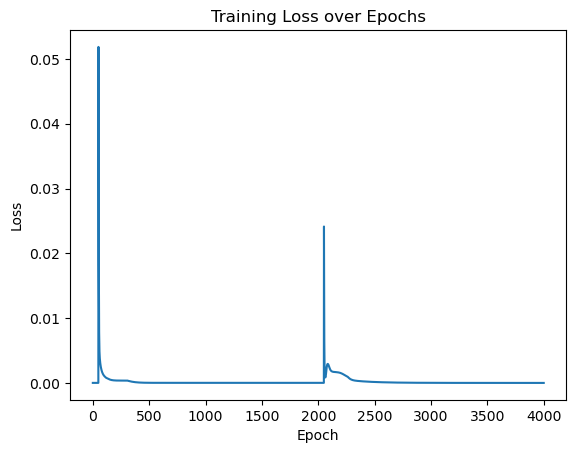

In [12]:
# Plotting the loss
plt.plot(range(simu_epochs), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

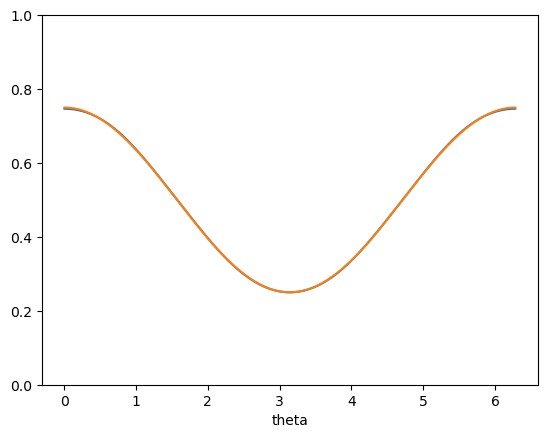

In [13]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

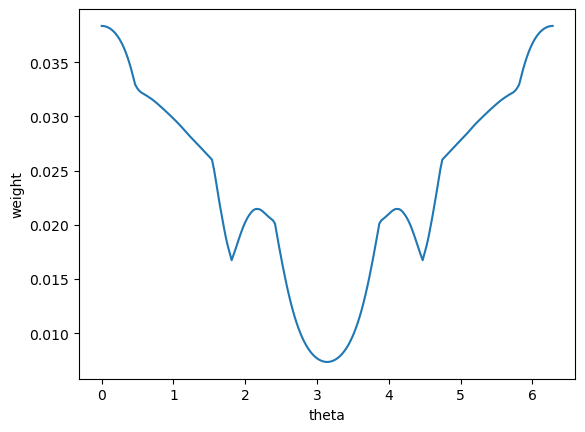

In [14]:
final_weight = model.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

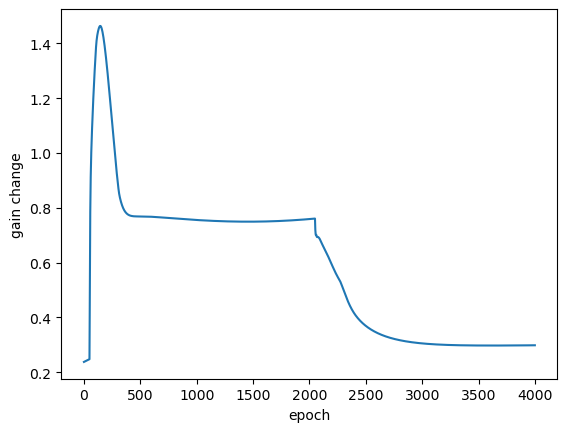

In [15]:
plt.plot(np.arange(simu_epochs), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

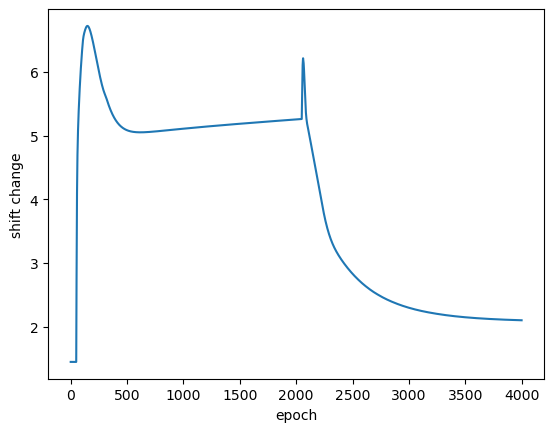

In [16]:
plt.plot(np.arange(simu_epochs), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

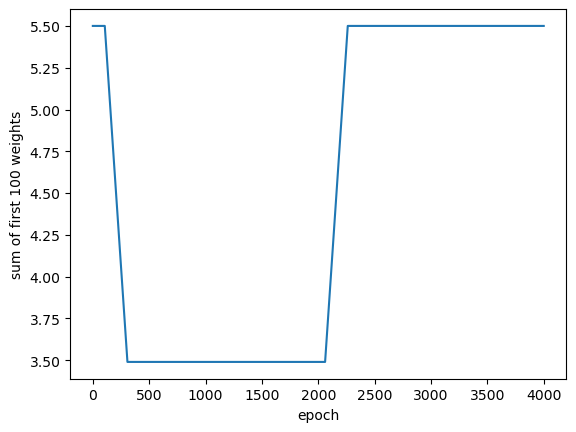

In [17]:
plt.plot(np.arange(simu_epochs), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

In [18]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5586, 0.5582, 0.5571, ..., 0.5571, 0.5582, 0.5586],
       [0.5582, 0.5584, 0.558 , ..., 0.5554, 0.5572, 0.5582],
       [0.557 , 0.5579, 0.5581, ..., 0.553 , 0.5554, 0.557 ],
       ...,
       [0.557 , 0.5554, 0.553 , ..., 0.5581, 0.5579, 0.557 ],
       [0.5582, 0.5572, 0.5554, ..., 0.558 , 0.5584, 0.5582],
       [0.5586, 0.5582, 0.5571, ..., 0.5571, 0.5582, 0.5586]],
      dtype=float32)

Text(0, 0.5, 'firing rate')

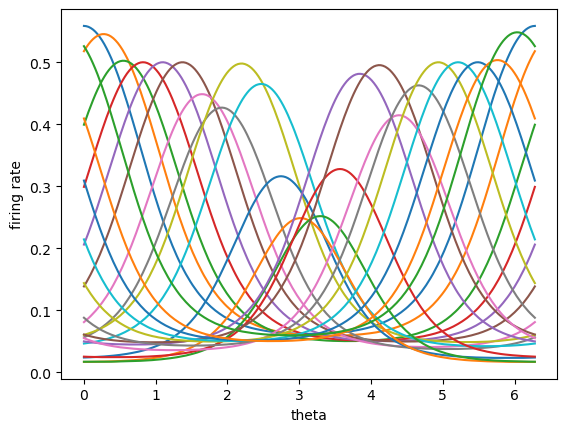

In [19]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
# plt.savefig('abb05_rf.png')

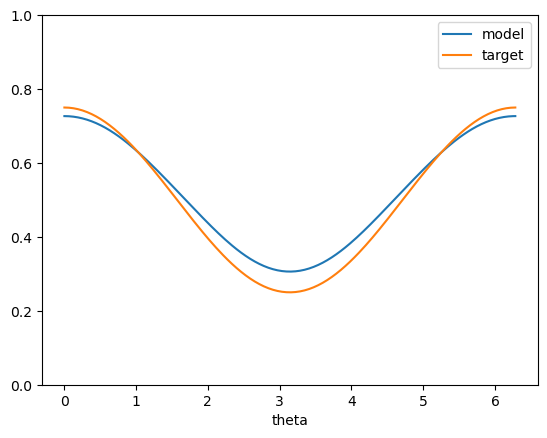

In [20]:
# Plotting the outputs
model.gain = model.init_gain
model.shift = model.init_shift
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')

### Different Perturbation Lasts

In [21]:
# manual simulation
perturb_lasts = [1000, 2000, 5000]

all_simu_losses = []
all_gain_changes = []
all_shift_changes = []
all_weight_sums = []

for perturb_last in perturb_lasts:

    print(f"perturb_last: {perturb_last}")

    simu_epochs = 8000
    perturb_start = 50
    # perturb_last = 500
    input_size = 230
    theo_gain = 3 * np.ones((input_size, 1))
    theo_shift = 1 * np.ones((input_size, 1))
    init_gain = model_rep.gain.detach().numpy()
    init_shift = model_rep.shift.detach().numpy()
    init_weight = model_rep.weights.detach().numpy()
    hebbian_lr = 0.03
    max_hebbian_lr = 0.001
    hebbian_up_rate = max_hebbian_lr / 200
    hebb_alpha = 5.5
    hebb_alpha_origin = 5.5
    hebb_alpha_perturb = 3.5
    hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 200
    backprop_lr = 0.2
    has_backprop = True
    has_boundary = False
    has_hebbian = True
    has_perturb = False

    # define noise
    np.random.seed(42)
    W = np.eye(input_size) * 0.001
    x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
    x_noises = torch.tensor(x_noises, dtype=torch.float32)
    x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

    simu_losses = []
    gain_changes = []
    shift_changes = []
    weight_sums = []
    epoch_loss = 0

    for epoch in tqdm(range(simu_epochs), position=0, leave=True):
        if epoch == perturb_start:
            has_perturb = True
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation start!!!")
        if epoch == perturb_start + perturb_last:
            has_perturb = False
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation end!!!")
        
        # shuffle data
        perm_idx = torch.randperm(ndata)
        shuffled_xs = xs[perm_idx]
        shuffled_ys = ys[perm_idx]
        last_epoch_loss = epoch_loss
        epoch_loss = 0
        hebbian_update = torch.zeros_like(torch.tensor(init_weight))

        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

        # start hebbian and shrinkage
        if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("perturb learning start!!!")
        if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("origin learning start!!!")
        # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
        #     gain_ub = np.maximum(init_gain, theo_gain)
        #     gain_lb = np.minimum(init_gain, theo_gain)
        #     shift_ub = np.maximum(init_shift, theo_shift)
        #     shift_lb = np.minimum(init_shift, theo_shift)
        #     has_boundary = True
        #     print("perturb boundary created!!!")
        if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
            gain_ub = np.maximum(init_gain, theo_gain)
            gain_lb = np.minimum(init_gain, theo_gain)
            shift_ub = np.maximum(init_shift, theo_shift)
            shift_lb = np.minimum(init_shift, theo_shift)
            has_boundary = True
            print("origin boundary created!!!")
     
        # update hebbian learning rate, once per epoch
        if has_hebbian and hebbian_lr < max_hebbian_lr:
            hebbian_lr += hebbian_up_rate
        if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
            hebb_alpha += hebb_alpha_up_rate
        if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
            hebb_alpha -= hebb_alpha_up_rate
        
        # go through all data
        for x, y in zip(shuffled_xs, shuffled_ys):  
            # forward
            inpu_ipl = model.gaussian_rf(x)
            actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
            # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
            model.input_activation = actv_ipl.clone()
            inpu_opl = torch.matmul(model.weights, actv_ipl)
            actv_opl = model.activation_func(3 * (inpu_opl - 1))
            model.output_activation = actv_opl.clone()          
            output = actv_opl.squeeze()
            # Calculate loss
            loss_func = nn.MSELoss()
            loss = 0.5 * loss_func(output, y)
            epoch_loss += loss
            # Calculate Hebbian weight updates
            hebbian_update += model.output_activation * (model.input_activation).T

        # backprop for gains and shifts
        if has_backprop:
            optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
            epoch_loss.backward()
            optimizer.step()
        # update init gains and shifts
        init_gain = model.gain.detach().numpy()
        init_shift = model.shift.detach().numpy()
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # hebbian learning for weights
        if has_hebbian:
            # Apply Hebbian updates and normalize
            model.weights = model.weights + hebbian_lr * hebbian_update
            model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
        # update init weights
        init_weight = model.weights.detach().numpy()

        # shrink shift and gain to init value
        if has_boundary:
            # passively narrow the boundaries
            # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
            # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
            # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
            # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
            # pull gains and shifts back to into boundaries
            init_gain = np.minimum(init_gain, gain_ub)
            init_gain = np.maximum(init_gain, gain_lb)
            init_shift = np.minimum(init_shift, shift_ub)
            init_shift = np.maximum(init_shift, shift_lb)

        # print losses
        epoch_loss /= ndata
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {epoch_loss}")

        # record
        simu_losses.append(epoch_loss.item())
        weight_sums.append(np.sum(init_weight))
        gain_changes.append(gain_change)
        shift_changes.append(shift_change)
    
    # record
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)
    all_weight_sums.append(weight_sums)

perturb_last: 1000


  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch: 0, Loss: 6.917841801623581e-06
perturbation start!!!
Epoch: 100, Loss: 0.001099810586310923
perturb learning start!!!
Epoch: 200, Loss: 0.00037787354085594416
Epoch: 300, Loss: 0.00036873517092317343
Epoch: 400, Loss: 7.564281258964911e-05
Epoch: 500, Loss: 1.936623993969988e-05
Epoch: 600, Loss: 1.3895516531192698e-05
Epoch: 700, Loss: 1.3456829947244842e-05
Epoch: 800, Loss: 1.3299578313308302e-05
Epoch: 900, Loss: 1.3129038052284159e-05
Epoch: 1000, Loss: 1.2953981240571011e-05
perturbation end!!!
origin learning start!!!
origin boundary created!!!
Epoch: 1100, Loss: 0.0026092994958162308
Epoch: 1200, Loss: 0.0012560917530208826
Epoch: 1300, Loss: 0.00044099424849264324
Epoch: 1400, Loss: 0.00023167653125710785
Epoch: 1500, Loss: 0.00013212606427259743
Epoch: 1600, Loss: 7.740843284409493e-05
Epoch: 1700, Loss: 4.70312443212606e-05
Epoch: 1800, Loss: 2.8844351618317887e-05
Epoch: 1900, Loss: 1.7849919458967634e-05
Epoch: 2000, Loss: 1.1219093721592799e-05
Epoch: 2100, Loss: 7

  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch: 0, Loss: 6.91784134687623e-06
perturbation start!!!
Epoch: 100, Loss: 0.0010998101206496358
perturb learning start!!!
Epoch: 200, Loss: 0.0003778743266593665
Epoch: 300, Loss: 0.0003687347925733775
Epoch: 400, Loss: 7.564282714156434e-05
Epoch: 500, Loss: 1.936620355991181e-05
Epoch: 600, Loss: 1.3895521078666206e-05
Epoch: 700, Loss: 1.3456874512485228e-05
Epoch: 800, Loss: 1.3299594684212934e-05
Epoch: 900, Loss: 1.3129039871273562e-05
Epoch: 1000, Loss: 1.2953963960171677e-05
Epoch: 1100, Loss: 1.2781861187249888e-05
Epoch: 1200, Loss: 1.2613414583029225e-05
Epoch: 1300, Loss: 1.2447251720004715e-05
Epoch: 1400, Loss: 1.2282024727028329e-05
Epoch: 1500, Loss: 1.2116476682422217e-05
Epoch: 1600, Loss: 1.1949975487368647e-05
Epoch: 1700, Loss: 1.1782005458371714e-05
Epoch: 1800, Loss: 1.1612379239522852e-05
Epoch: 1900, Loss: 1.1441052265581675e-05
Epoch: 2000, Loss: 1.1268108210060745e-05
perturbation end!!!
origin learning start!!!
origin boundary created!!!
Epoch: 2100, Loss

  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch: 0, Loss: 6.917840437381528e-06
perturbation start!!!
Epoch: 100, Loss: 0.0010998101206496358
perturb learning start!!!
Epoch: 200, Loss: 0.00037787389010190964
Epoch: 300, Loss: 0.0003687355201691389
Epoch: 400, Loss: 7.564297266071662e-05
Epoch: 500, Loss: 1.9366210835869424e-05
Epoch: 600, Loss: 1.3895536540076137e-05
Epoch: 700, Loss: 1.3456857232085895e-05
Epoch: 800, Loss: 1.3299611964612268e-05
Epoch: 900, Loss: 1.312901804340072e-05
Epoch: 1000, Loss: 1.2953957593708765e-05
Epoch: 1100, Loss: 1.2781871191691607e-05
Epoch: 1200, Loss: 1.2613397302629892e-05
Epoch: 1300, Loss: 1.2447259905457031e-05
Epoch: 1400, Loss: 1.228201472258661e-05
Epoch: 1500, Loss: 1.2116511243220884e-05
Epoch: 1600, Loss: 1.194997184938984e-05
Epoch: 1700, Loss: 1.1781984539993573e-05
Epoch: 1800, Loss: 1.1612369235081133e-05
Epoch: 1900, Loss: 1.1441040442150552e-05
Epoch: 2000, Loss: 1.1268100934103131e-05
Epoch: 2100, Loss: 1.1093823559349403e-05
Epoch: 2200, Loss: 1.0918601219600532e-05
Epoch

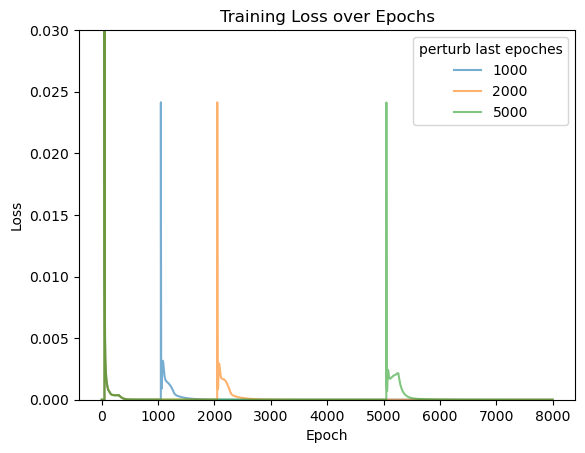

In [34]:
# Plotting the loss
for i, simu_losses in enumerate(all_simu_losses):
    plt.plot(range(simu_epochs), simu_losses, label=perturb_lasts[i], alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.03])
plt.title('Training Loss over Epochs')
plt.legend(title='perturb last epoches')
plt.savefig('fig/0122_abb05_perturb_loss.png')
plt.show()

In [42]:
for simu_losses in all_simu_losses:
    
    retain_epochs = 0
    perturb_started = False

    for i, loss in enumerate(simu_losses):
        if i > 1000 and loss > 0.01:
            perturb_started = True
        
        if perturb_started:
            retain_epochs += 1

        if perturb_started and loss < 0.0001:
            break

    print(retain_epochs)

503
524
491


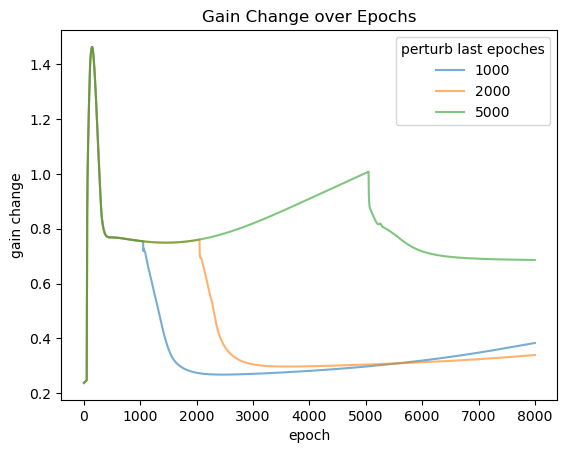

In [43]:
for i, gain_changes in enumerate(all_gain_changes):
    plt.plot(np.arange(simu_epochs), gain_changes, label=perturb_lasts[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("gain change")
plt.legend(title='perturb last epoches')
plt.title('Gain Change over Epochs')
plt.savefig('fig/0122_abb05_perturb_gc.png')

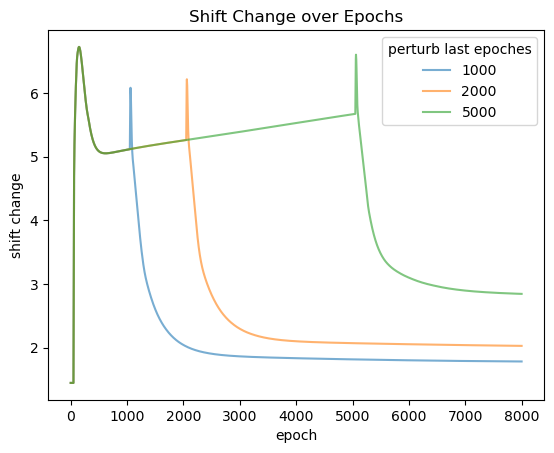

In [44]:
for i, shift_changes in enumerate(all_shift_changes):
    plt.plot(np.arange(simu_epochs), shift_changes, label=perturb_lasts[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("shift change")
plt.legend(title='perturb last epoches')
plt.title('Shift Change over Epochs')
plt.savefig('fig/0122_abb05_perturb_sc.png')